# Create Individual Deforestation Files From Hansen Dataset

# Import the necessary libraries and load the datasets.


In [46]:
import os
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.transform import from_origin
import geopandas as gpd
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from constants import HANSEN_FILEPATHS, PROPERTIES_SHAPEFILE_PATHS, PROJECT_PATH, SHAPEFILE_PATH

# Mosaic the Hansen tiles.

In [3]:
# Mosaic the Hansen tiles
'''def mosaic_hansen_tiles(filepaths):
    src_files_to_mosaic = [rasterio.open(fp) for fp in filepaths]
    mosaic, out_transform = merge(src_files_to_mosaic)
    out_meta = src_files_to_mosaic[0].meta.copy()
    for src in src_files_to_mosaic:
        src.close()
    return mosaic, out_transform, out_meta

mosaic, out_transform, out_meta = mosaic_hansen_tiles(HANSEN_FILEPATHS)'''



# Load the Study boundary dataset and crop the mosaic to the property boundaries.

In [4]:
'''study_boundary_gdf = gpd.read_file(SHAPEFILE_PATH)


# Reproject the study boundary to match the Hansen raster CRS
with rasterio.open(HANSEN_FILEPATHS[0]) as src:
    hansen_crs = src.crs

# Reproject the study boundary GeoDataFrame to match the Hansen raster CRS    
study_boundary_gdf_reprojected = study_boundary_gdf.to_crs(hansen_crs)
# Get the geometry column from the reprojected GeoDataFrame
study_boundary_geom_reprojected = study_boundary_gdf_reprojected.geometry
'''



In [4]:
hansen_filepath = "/Users/romero61/../../capstone/pyforest/ml_data/hansen/clipped_hansen_lossyear.tiff"


In [5]:
# Check the CRS of the Hansen raster
with rasterio.open(hansen_filepath) as src:
    hansen_crs = src.crs
print("Hansen CRS:", hansen_crs)

'''# Check the CRS of the study boundary
print("Properties CRS:", study_boundary_gdf.crs)'''

Hansen CRS: EPSG:4326


'# Check the CRS of the study boundary\nprint("Properties CRS:", study_boundary_gdf.crs)'

In [32]:
#read the data from the Hansen raster file into a NumPy array,
with rasterio.open(hansen_filepath) as hansen:
    hansen_array = hansen.read(1)
    hansen_crs = hansen.crs
    out_transform = hansen.transform
    out_meta = hansen.meta


In [6]:
# Crop the mosaic using the study boundary polygon
'''with rasterio.open(HANSEN_FILEPATHS[0]) as src:
    out_meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': out_transform
    })
    with rasterio.open('mosaic.tif', 'w', **out_meta) as dst:
        dst.write(mosaic)
    study_boundary_masked, _ = mask(rasterio.open('mosaic.tif'), study_boundary_geom_reprojected, crop=True, indexes=1)'''



In [7]:
#print("Shape of study_boundary_masked:", study_boundary_masked.shape)


Shape of study_boundary_masked: (24267, 21971)


Text(0.5, 1.0, 'Cropped Mosaic')

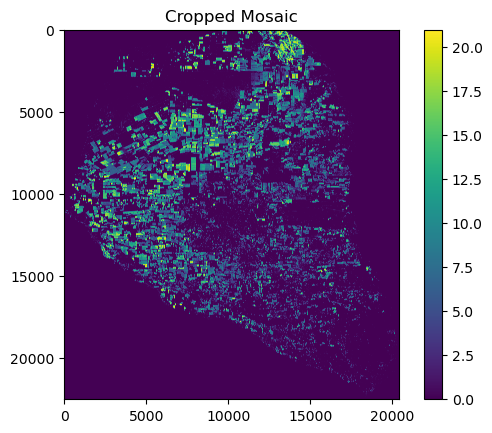

In [7]:
plt.imshow(hansen_array.astype(float), cmap='viridis')
plt.colorbar()
plt.title("Cropped Mosaic")


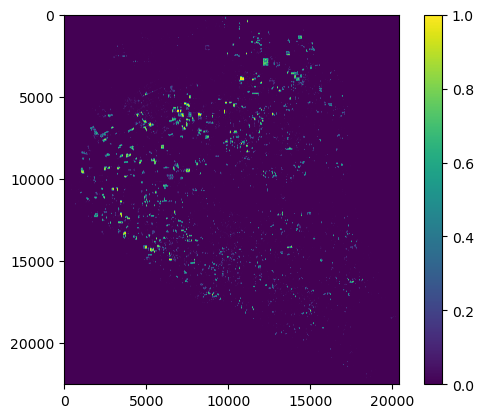

In [28]:
# Extract pixels with a value of 11
pixels_value_11 = (hansen_array == 11).astype(int)

# Plot the pixels with a value of 11
plt.imshow(pixels_value_11, cmap='viridis')
plt.colorbar()
plt.show()

# Extract pixels corresponding to each year (2011-2021).


Returns pixels encoded with value of 1 and zeros as NaN.
if `year_pixels[year_pixels == 0] = np.nan` is removed then will return [0 1]. 

In [39]:
# Extract pixels corresponding to each year (2011-2021)
def extract_pixels_by_year(raster_data, start_year, end_year):
    year_data = {}
    for year in range(start_year, end_year + 1):
        year_pixels = (raster_data == year).astype(int) 
        year_data[year] = year_pixels

        # Print unique values for each year
        unique_values = np.unique(year_pixels)
        print(f"Unique values for year {year + 2000}: {unique_values}") # Add 2000 to the year to get the correct year values
    return year_data

pixels_by_year = extract_pixels_by_year(study_boundary_masked, 11, 21)




Unique values for year 2011: [0 1]
Unique values for year 2012: [0 1]
Unique values for year 2013: [0 1]
Unique values for year 2014: [0 1]
Unique values for year 2015: [0 1]
Unique values for year 2016: [0 1]
Unique values for year 2017: [0 1]
Unique values for year 2018: [0 1]
Unique values for year 2019: [0 1]
Unique values for year 2020: [0 1]
Unique values for year 2021: [0 1]


Returns pixels encoded with value of corresponding year(11,12,13...) and zeros as NaN.
if `year_pixels[year_pixels == 0] = np.nan` is removed then will return [0 11]. 

In [30]:
def extract_pixels_by_year(raster_data, start_year, end_year):
    year_data = {}
    for year in range(start_year, end_year + 1):
        year_pixels = (raster_data == year).astype(int) * year
        year_data[year] = year_pixels

        # Print unique values for each year
        unique_values = np.unique(year_pixels)
        print(f"Unique values for year {year + 2000}: {unique_values}") # Add 2000 to the year to get the correct year values
             
    return year_data

pixels_by_year = extract_pixels_by_year(hansen_array, 11, 21)

Unique values for year 2011: [ 0 11]
Unique values for year 2012: [ 0 12]
Unique values for year 2013: [ 0 13]
Unique values for year 2014: [ 0 14]
Unique values for year 2015: [ 0 15]
Unique values for year 2016: [ 0 16]
Unique values for year 2017: [ 0 17]
Unique values for year 2018: [ 0 18]
Unique values for year 2019: [ 0 19]
Unique values for year 2020: [ 0 20]
Unique values for year 2021: [ 0 21]


# Write raster files for each year 

In [33]:
# Write raster files for each year
def write_year_rasters(year_data, out_transform, out_meta, output_dir):
    for year, data in year_data.items():
        out_filepath = os.path.join(output_dir, f'deforestation_{year}.tif')
        with rasterio.open(out_filepath, 'w', **out_meta) as dst:
            dst.write(data, 1)
            dst.transform = out_transform

output_dir = os.path.join(PROJECT_PATH, 'output', 'deforestation_by_year')
os.makedirs(output_dir, exist_ok=True)

write_year_rasters(pixels_by_year, out_transform, out_meta, output_dir)


In [ ]:
# Read one of the TIF files and print its unique values
with rasterio.open("/Users/romero61/github/PYFOREST-ML/output/deforestation_by_year/deforestation_11.tif") as src:
    data = src.read(1)
print("Unique values in uncropped TIF:", np.unique(data))

# Crop Hansen Dataset within Property

In [48]:
shapefile_2011_path = PROPERTIES_SHAPEFILE_PATHS[0]  # The first file in the list should be for 2011
properties_2011 = gpd.read_file(shapefile_2011_path)
# Check the CRS
crs = properties_2011.crs
print("CRS:", crs)

# Reproject the shapefile to EPSG:4326 if necessary
if crs != "epsg:4326":
    properties_2011 = properties_2011.to_crs("epsg:4326")



CRS: PROJCS["WGS 84 / UTM zone 21S",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32721"]]


In [42]:
 # Define the deforestation_11 and treecover2000 file paths
deforestation_11_filepath = os.path.join('/Users/romero61/../../capstone/pyforest/ml_data/hansen/deforestation_by_year/deforestation_11.tif')
treecover2000_filepath = '/Users/romero61/../../capstone/pyforest/ml_data/hansen/clipped_treecover2000.tif'

In [44]:
# Crop and mask the deforestation_11 and treecover2000 files
def crop_and_mask(input_raster_path, output_raster_path, shapefile):
    with rasterio.open(input_raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)


In [49]:


# Create output directory for cropped rasters
cropped_output_dir = Path(output_dir) / 'cropped'
os.makedirs(cropped_output_dir, exist_ok=True)

# Crop and mask deforestation_11 file
crop_and_mask(deforestation_11_filepath, cropped_output_dir / 'cropped_deforestation_11.tif', properties_2011)

# Crop and mask treecover2000 file
crop_and_mask(treecover2000_filepath, cropped_output_dir / 'cropped_treecover2000.tif', properties_2011)

In [ ]:
plt.imshow(pixels_value_11, cmap='viridis')
plt.colorbar()
plt.show()